# Obtain American Community Survey Data from api.census.gov
This code demonstrates how to obtain ACS data from the US Census API

For more details on the ACS and Census API see the [ReadMe.md File](ReadMe.md)

## Description of Program
- program:    acg_1av1_ACS #acg short for api.census.gov
- task:       Code to obtain ACS data
- Version:    2026-02-17
- project:    Urban Analytics URSC 645
- funding:	  Texas A&M University Department of Landscape Architecture and Urban Planning
- author:     Nathanael Rosenheim

In [4]:
# Python packages required to read in and Census API data
import requests         # Required for the Census API
import pandas as pd     # For reading, writing and wrangling data
import numpy as np      # For data cleaning
import sys              # For displaying package versions

In [5]:
# Check python and package versions - important for replicating work
print("Python Version    : ", sys.version)
print("pandas version    : ", pd.__version__)
print("numpy version     : ", np.__version__)

Python Version    :  3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:06:27) [MSC v.1942 64 bit (AMD64)]
pandas version    :  2.2.3
numpy version     :  2.2.1


In [20]:
program_name = "acg_1av1_ACS"

## Step 1: Obtain Data
This example uses the Census API to get all the block groups for an individual county. (`state:48_county:167`). The api request could be modified to get all the data for the entire state, but this would be a very large file to work with.

In [6]:
state    = '48'     # State FIPS Code   
# List of County FIPS Codes within the same state
county = '167'
acs_year = '2022'   # ACS Year
srvy     = '5'      # 5-year or 1-year ACS Single-Year or Multiyear Estimates

# Variables to get
var = 'B19013' 
# B03002 = HISPANIC OR LATINO ORIGIN BY RACE, 
# B19013 = Median Household Income

In [ ]:
# Set up hyperlink for Census API
api_hyperlink = (f'https://api.census.gov/data/{acs_year}/acs/acs{srvy}?get=group({var})' +
                    f'&in=state:{state}+county:{county}&for=block%20group:*')
print("Census API data from: "+ api_hyperlink)

# Obtain Census API JSON Data
api_json = requests.get(api_hyperlink)
# Convert the requested json into pandas dataframe
api_df = pd.DataFrame(columns=api_json.json()[0], data=api_json.json()[1:])

Census API data from: https://api.census.gov/data/2022/acs/acs5?get=group(B19013)&in=state:48+county:167&for=block%20group:*


In [9]:
api_df.head(1)

,B19013_001E,B19013_001EA,B19013_001M,B19013_001MA,GEO_ID,NAME,state,county,tract,block group
0,86840,None,33360,None,1500000US481677201001,Block Group 1; Census Tract 7201; Galveston Co...,48,167,720100,1


# Step 2: Data cleaning
In this step we will clean the data file.
Currently the Median Income Data is stored as a string and needs to be converted to a number.

In [10]:
api_df[['GEO_ID','state','county']].describe()

,GEO_ID,state,county
count,276,276,276
unique,276,1,1
top,1500000US481679901000,48,167
freq,1,276,276


In [11]:
### 2.1 Set the variable type
api_df[f"{var}_001E"] = api_df[f"{var}_001E"].astype(int)
api_df[f"{var}_001M"] = api_df[f"{var}_001M"].astype(int)

In [12]:
pd.option_context('float_format', '{:,.0f}'.format)
api_df[[f'{var}_001E', f'{var}_001M']].describe()

,B19013_001E,B19013_001M
count,2.760000e+02,2.760000e+02
mean,-8.928821e+07,-3.217480e+07
std,2.275887e+08,8.008321e+07
min,-6.666667e+08,-3.333333e+08
25%,4.706975e+04,1.335125e+04
50%,8.048800e+04,2.372500e+04
75%,1.141808e+05,4.466975e+04
max,2.500010e+05,1.995990e+05


## Replace Missing Data Codes
Notice that missing data is flagged as -666666666 and -222222222.
The details of these codes can be found in the Notes tab on data.census.gov

See [ReadMe.md File](ReadMe.md) for more details on missing data codes.


In [13]:
api_df.loc[api_df[f"{var}_001E"]==-666666666].head(5)

,B19013_001E,B19013_001EA,B19013_001M,B19013_001MA,GEO_ID,NAME,state,county,tract,block group
20,-666666666,-,-222222222,**,1500000US481677205041,Block Group 1; Census Tract 7205.04; Galveston...,48,167,720504,1
28,-666666666,-,-222222222,**,1500000US481677205071,Block Group 1; Census Tract 7205.07; Galveston...,48,167,720507,1
53,-666666666,-,-222222222,**,1500000US481677207011,Block Group 1; Census Tract 7207.01; Galveston...,48,167,720701,1
55,-666666666,-,-222222222,**,1500000US481677207013,Block Group 3; Census Tract 7207.01; Galveston...,48,167,720701,3
57,-666666666,-,-222222222,**,1500000US481677207022,Block Group 2; Census Tract 7207.02; Galveston...,48,167,720702,2


In [15]:
# in the data frame locate the observations and replace the varaible with the new value
api_df.loc[api_df[f"{var}_001E"]==-666666666, f"{var}_001E"] = np.nan
api_df.loc[api_df[f"{var}_001M"]==-222222222, f"{var}_001M"] = np.nan

# Check cleaned variables
api_df[[f'{var}_001E', f'{var}_001M']].describe()

,B19013_001E,B19013_001M
count,239.000000,2.390000e+02
mean,96742.644351,-2.753230e+06
std,50275.173356,3.043184e+07
min,16973.000000,-3.333333e+08
25%,60570.000000,1.819050e+04
50%,88664.000000,2.785400e+04
75%,121817.500000,5.011300e+04
max,250001.000000,1.995990e+05


In [34]:
# Add GEOID for merge with shapefile
api_df['BGGEOID20'] = api_df['state'] + api_df['county'] + api_df['tract'] + api_df['block group']
api_df['BGGEOID20'].describe()

count              276
unique             276
top       481679901000
freq                 1
Name: BGGEOID20, dtype: object

In [35]:
# Add survey year
api_df['ACSyr'] = acs_year
# reorder and drop columns
api_df_v2 = api_df[['BGGEOID20', 'ACSyr', f'{var}_001E', f'{var}_001M']].copy()
api_df_v2.head(1)

,BGGEOID20,ACSyr,B19013_001E,B19013_001M
0,481677201001,2022,86840.0,33360.0


## Step 3: Explore Data

In [36]:
api_df_v2.describe().T

,count,mean,std,min,25%,50%,75%,max
B19013_001E,239.0,9.674264e+04,5.027517e+04,16973.0,60570.0,88664.0,121817.5,250001.0
B19013_001M,239.0,-2.753230e+06,3.043184e+07,-333333333.0,18190.5,27854.0,50113.0,199599.0


<Axes: >

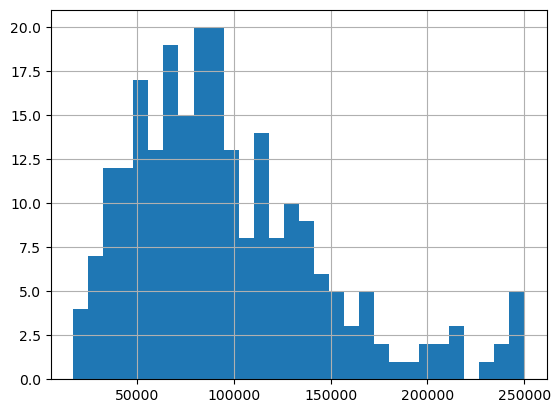

In [37]:
# make a histogram of the median household income variable
api_df_v2[f'{var}_001E'].hist(bins=30)

### Look at metadata for Data Dictionary

In [32]:
# read in json to pandas
json_url = f'https://api.census.gov/data/{acs_year}/acs/acs{srvy}/groups/{var}.json'
print("Census API metadata from: "+ json_url)
metadata_json = pd.read_json(json_url)
metadata_json_df = metadata_json.variables.apply(pd.Series)
# The variable name is in the index column - reset index move name
metadata_df = metadata_json_df.reset_index()
# rename index column
metadata_df = metadata_df.rename(columns={"index": "name"})
# sort by name
metadata_df = metadata_df.sort_values(by='name')
metadata_df.head(10)

Census API metadata from: https://api.census.gov/data/2022/acs/acs5/groups/B19013.json


,name,label,concept,predicateType,group,limit,predicateOnly,universe
4,B19013_001E,Estimate!!Median household income in the past ...,Median Household Income in the Past 12 Months ...,int,B19013,0,True,Households
1,B19013_001EA,Annotation of Estimate!!Median household incom...,Median Household Income in the Past 12 Months ...,string,B19013,0,True,Households
5,B19013_001M,Margin of Error!!Median household income in th...,Median Household Income in the Past 12 Months ...,int,B19013,0,True,Households
0,B19013_001MA,Annotation of Margin of Error!!Median househol...,Median Household Income in the Past 12 Months ...,string,B19013,0,True,Households
3,GEO_ID,Geography,"Sex by Occupation for the Full-Time, Year-Roun...",string,B19013,0,True,Households
2,NAME,Geographic Area Name,"Sex by Occupation for the Full-Time, Year-Roun...",string,B19013,0,True,Households


In [41]:
# Create Data Dictionary
data_dictionary = metadata_df[['name', 'label', 'concept']].copy()
# drop observations not in column list from api_df_v2
data_dictionary = data_dictionary[data_dictionary['name'].isin([f'{var}_001E', f'{var}_001M'])]
# add row for ACS year
data_dictionary.loc[len(data_dictionary.index)] = [f'ACSyr', 'ACS Year', 'The year of the ACS survey data']
# add row for BGGEOID20
data_dictionary.loc[len(data_dictionary.index)] = ['BGGEOID20', 'Block Group GEOID 2020', 'The 12-digit GEOID for the block group']
# sort by name
data_dictionary = data_dictionary.sort_values(by='name')
data_dictionary.head(10)

,name,label,concept
2,ACSyr,ACS Year,The year of the ACS survey data
4,B19013_001E,Estimate!!Median household income in the past ...,Median Household Income in the Past 12 Months ...
5,B19013_001M,Margin of Error!!Median household income in th...,Median Household Income in the Past 12 Months ...
3,BGGEOID20,Block Group GEOID 2020,The 12-digit GEOID for the block group


# Save Cleaned Datafile

In [29]:
# Save the data to a csv file
file_suffix = (f'ACS{acs_year}_{srvy}_{var}_{state}{county}')
file_name = f"{program_name}_{file_suffix}.csv"
api_df_v2.to_csv(file_name, index=False)

In [43]:
# save data dictionary to csv
data_dictionary_file_name = f"{program_name}_{file_suffix}_metadata.csv"
data_dictionary.to_csv(data_dictionary_file_name, index=False)